# Vine Copula Auto-encoder

This notebook presents a vine copula auto-encoder ([paper](https://arxiv.org/abs/1906.05423)) for trajectory generation.

The basic idea is to learn the distribution in the latent space of a pre-trained auto-encoder using a vine copula.
Sampling from the vine to feed the auto-encoder's decoder will produce new trajectories.

In [1]:
import altair as alt

from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import pyvinecopulib as pv

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

Data Loading

In [2]:
dataset = TrafficDataset(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    init_features=["latitude", "longitude"],
    scaler=MinMaxScaler(feature_range=(-1, 1)),
    mode="image",
)
dataset

Dataset TrafficDataset
    Number of datapoints: 3968
    File location: ../deep_traffic_generation/data/traffic_15.pkl
    MinMaxScaler(feature_range=(-1, 1))

Model Loading

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_0/checkpoints/epoch=2749-step=8249.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_0/hparams.yaml",
    x_dim = dataset.input_dim,
    seq_len=dataset.seq_len,
    scaler = dataset.scaler,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

Compute representation in latent space for every trajectories

In [4]:
z, _ = model.encoder(torch.Tensor(dataset.dense))
z.size()

torch.Size([3968, 32])

In [5]:
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [6]:
original, _, info = dataset[0]
_, reconstruction = model(original.unsqueeze(0))

data = np.concatenate((original.unsqueeze(0).numpy(), reconstruction.detach().numpy()))
data = np.transpose(data, (0, 2, 1))
data.shape

(2, 200, 4)

In [7]:
data = data.reshape(data.shape[0], -1)
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [8]:
info = info.repeat(2, 1)
info.size()

torch.Size([2, 2])

In [9]:
# add latitude longitude info
data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic

(2, 802)


,count
flight_id,
0,200
1,200


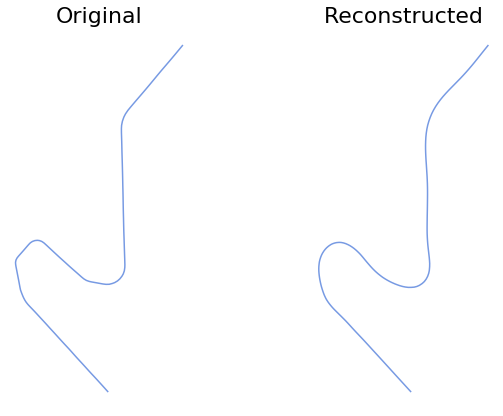

In [10]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Original")
    traffic[0].plot(ax[0])
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

### Generation

Transform copula data using the empirical distribution

In [11]:
u = pv.to_pseudo_obs(x)

Fit a vine

In [12]:
# family_set=[
#        pv.BicopFamily.indep,
#        pv.BicopFamily.gaussian,
#        pv.BicopFamily.clayton,
#        pv.BicopFamily.gumbel,
#        pv.BicopFamily.frank,
#        pv.BicopFamily.joe,
#    ],
controls = pv.FitControlsVinecop(
    num_threads=4,
)
vine = pv.Vinecop(data=u, controls=controls)
vine

<pyvinecopulib.Vinecop>
** Tree: 0
15,28 <-> BB8 180°, parameters =  1.27452
0.876316
2,26 <-> Student, parameters = 0.085012
 5.19391
32,11 <-> Student, parameters = 0.069506
 8.49556
18,26 <-> Student, parameters = 0.160503
 6.12484
17,5 <-> Student, parameters = -0.113814
  9.88536
11,4 <-> Student, parameters = 0.0983362
  12.0177
29,4 <-> Student, parameters = -0.0973624
   10.5289
21,14 <-> Clayton 270°, parameters = 0.244719
6,23 <-> Student, parameters = 0.0441343
  8.92063
4,3 <-> Frank, parameters = -0.959092
20,13 <-> Student, parameters = 0.115689
 4.63504
16,5 <-> Student, parameters = -0.0866768
   9.70996
30,22 <-> TLL, parameters = [30x30 grid]
9,26 <-> Student, parameters = -0.0929847
   7.36874
3,22 <-> TLL, parameters = [30x30 grid]
10,5 <-> Student, parameters = 0.10769
4.79176
22,12 <-> TLL, parameters = [30x30 grid]
26,24 <-> Student, parameters = 0.0886595
  9.42297
12,23 <-> Clayton 270°, parameters = 0.183957
5,14 <-> Student, parameters = 0.195695
 8.30893
31,

Sample from the copula

In [13]:
u_sim = vine.simulate(n=100, seeds=[42])

Transform back simulations to the original scale

In [14]:
x_sim = np.asarray([np.quantile(x[:, i], u_sim[:, i]) for i in range(0, 32)])
x_sim = x_sim.transpose(1, 0)
x_sim.shape

(100, 32)

In [15]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(4068, 32)

In [16]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(4068, 2)

Plot embeddings (blue=original, red=sampled)

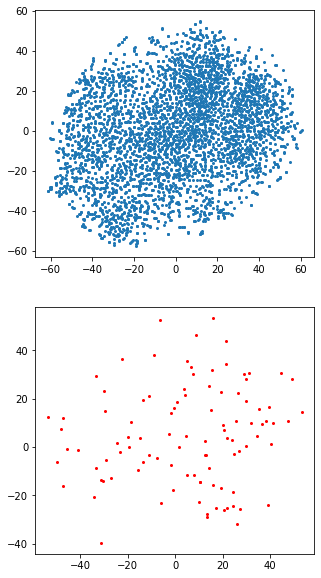

In [17]:
fig, ax = plt.subplots(2, figsize=(5, 10))
ax[0].scatter(z_embedded[:3968, 0], z_embedded[:3968, 1], s=4)
ax[1].scatter(z_embedded[3968:, 0], z_embedded[3968:, 1], s=4, c='red')
plt.show()

Find closest original trajectories

In [18]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: (32, 100)
X real: (32, 3968)


In [19]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [20]:
originals, _, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([100, 200, 4])

In [21]:
data = originals.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [22]:
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic_original

,count
flight_id,
0,200
66,200
75,200
74,200
73,200
72,200
71,200
70,200
7,200


Decode generated samples

In [23]:
outputs = model.decoder(torch.Tensor(x_sim))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([100, 200, 4])

In [24]:
data = outputs.detach().numpy()
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [25]:
# add latitude longitude info
# info = np.ones((20, 2)) * 40
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0])
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_generated = traffic_from_data(
    data, features, model.hparams.init_features, builder=builder
)
traffic_generated

,count
flight_id,
0,200
66,200
75,200
74,200
73,200
72,200
71,200
70,200
7,200


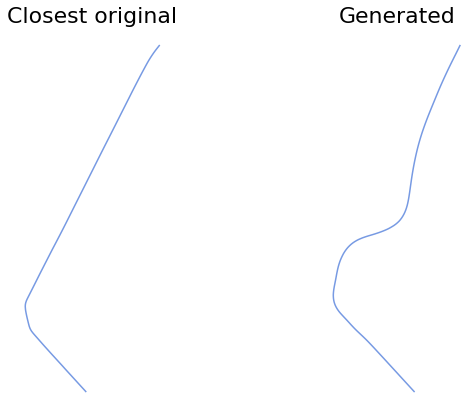

In [26]:
flight_id = 0
generated = traffic_generated[str(flight_id)]
original = traffic_original[str(flight_id)]

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Closest original")
    original.plot(ax[0])
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [27]:
generated.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [28]:
original.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [29]:
traffic_generated.to_csv("./outputs/vcae_gen.csv")